# MCT4052 Workshop 7c: Gesture Recognition

*Author: Stefano Fasciani, stefano.fasciani@imv.uio.no, Department of Musicology, University of Oslo.*

The recognition (classification) of a gesture (i.e. dynamic movement) is a much more complex task than what explored in the previous notebooks. In particular there are two challenges:
1. The gesture may be performed at a faster/slower speed than the "training" templates (expecting equal speed is unrealistic application-wise), and therefore the classification requires to perform "template matching" of time series with different lenght. These time series may be "multivariate", i.e. containing multiple variables changing over time, such as a collection of sensors or the 3-axis accelerometer data.  
2. In a real-world application, especially those working in real-time, we have to find a strategy to identify/detect temporal segments of gestures (i.e. when to start and end sampling gestural data to be passed to the classifier), or to decide lenght and frequency (including eventual overlaps) at which we sample temporal sequence and pass these to the classifier.

In this notebook we address the issue discussed in 1. while 2. is out of the scope of this notebook as the appropriate strategy would be strictly application- and resource-dependant.

The techniques described in this notebook applies to time-series data.

In particular in this notebook we introduce the [Dynamic Time Warping (DTW)](https://medium.com/@shachiakyaagba_41915/dynamic-time-warping-with-time-series-1f5c05fb8950) technique, which allows to measure the "distance" between time series of arbitrary (and fidderent distance) distance. We use the DTW implementation available in [tslearn](https://tslearn.readthedocs.io/en/stable/index.html), which support univariate and multivariate DWT.

In ML often we store all examples in a Numpy array, which only supports vectors of equal lenght. Utulities that may help to in this context are [numpy.pad](https://numpy.org/doc/stable/reference/generated/numpy.pad.html) to pad examples to a pre defined identical lenght (likely the longest), and [Sequentia Constant Trimming](https://sequentia.readthedocs.io/en/latest/sections/preprocessing/trim_constants.html) to remove constant values from a vector. However, in the following example we store our examples as a list of Numpy arrays, so that possible lenght are allowed.

The most straight-forward approach to recognize (i.e. classify) a gesture is to take the KNN approach and replace the Eucliden distance with the DWT. This can be easily implemented from scratch (also the DWT implementation is quite straight forward, as described [here](https://en.wikipedia.org/wiki/Dynamic_time_warping)), and is apready implemented in [Sequentia](https://sequentia.readthedocs.io/en/latest/sections/classifiers/knn.html).

As the size of the database grow, the computational complexity may become unfeasible, as KNN is a lazy learner, and the DWT (more expensive than the Euclidean distance) has to be computed versus all examples in the database. Also the length (i.e. temporal dutation) of the gestures has also an impact on the computational complexity.

Another aspect to consider is that classifiers will predict a class included in the training set, even when the input is significantly different than those in the database. For this reason it may be appropriate to add more examples with noisy gestures (labeled so that the follow up system takes no action). An aplternative approach with KNN is to set a minimum treshold for valid distances between the example to be classified and those in the dataset.

Another approach (better as not based on lazy learners) is to use a [Hidden Markov Model (HMM)](https://analyticsindiamag.com/a-guide-to-hidden-markov-model-and-its-applications-in-nlp/), which is also provided with simplified API in [Sequentia](https://sequentia.readthedocs.io/en/latest/index.html).

In the examples of this notebook we use synthetic gestural data (i.e. computer generated). More gesture/movement related dataset can be found over the Internet, such as the [Daily and Sports Activities Data Set](https://archive.ics.uci.edu/ml/datasets/daily+and+sports+activities) (which has a low/no direct relationship with music).

In [1]:
import os
import numpy as np
import scipy
import matplotlib.pyplot as plt
import matplotlib.style as ms
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt
import sklearn
from tslearn import metrics
ms.use('seaborn-muted')
%matplotlib inline

### 1. DTW distance and similarith path

In this example we use five univatiate sequences, s1, s2, s3, s4, s5. These have been generated from s1 by: inverting the second half (s2), adding noise (s3), zero padding the beginning of the sequence (s4). The sequence s5 contains just noise. The following code shows their respective DTW distance (using tslearn metrics.dtw_path()) and visualizes their similarity path.

We also compute the DTW distance (also called similarity, the lower the better) between two multivariate sequences s6 and s7. 

In [2]:
# SYNTHETIC DATA GENERATION

# starting sequence
s = np.array(
    [-0.790, -0.765, -0.734, -0.700, -0.668, -0.639, -0.612, -0.587, -0.564,
     -0.544, -0.529, -0.518, -0.509, -0.502, -0.494, -0.488, -0.482, -0.475,
     -0.472, -0.470, -0.465, -0.464, -0.461, -0.458, -0.459, -0.460, -0.459,
     -0.458, -0.448, -0.431, -0.408, -0.375, -0.333, -0.277, -0.196, -0.090,
     0.047, 0.220, 0.426, 0.671, 0.962, 1.300, 1.683, 2.096, 2.510, 2.895,
     3.219, 3.463, 3.621, 3.700, 3.713, 3.677, 3.606, 3.510, 3.400, 3.280,
     3.158, 3.038, 2.919, 2.801, 2.676, 2.538, 2.382, 2.206, 2.016, 1.821,
     1.627, 1.439, 1.260, 1.085, 0.917, 0.758, 0.608, 0.476, 0.361, 0.259,
     0.173, 0.096, 0.027, -0.032, -0.087, -0.137, -0.179, -0.221, -0.260,
     -0.293, -0.328, -0.359, -0.385, -0.413, -0.437, -0.458, -0.480, -0.498,
     -0.512, -0.526, -0.536, -0.544, -0.552, -0.556, -0.561, -0.565, -0.568,
     -0.570, -0.570, -0.566, -0.560, -0.549, -0.532, -0.510, -0.480, -0.443,
     -0.402, -0.357, -0.308, -0.256, -0.200, -0.139, -0.073, -0.003, 0.066,
     0.131, 0.186, 0.229, 0.259, 0.276, 0.280, 0.272, 0.256, 0.234, 0.209,
     0.186, 0.162, 0.139, 0.112, 0.081, 0.046, 0.008, -0.032, -0.071, -0.110,
     -0.147, -0.180, -0.210, -0.235, -0.256, -0.275, -0.292, -0.307, -0.320,
     -0.332, -0.344, -0.355, -0.363, -0.367, -0.364, -0.351, -0.330, -0.299,
     -0.260, -0.217, -0.172, -0.128, -0.091, -0.060, -0.036, -0.022, -0.016,
     -0.020, -0.037, -0.065, -0.104, -0.151, -0.201, -0.253, -0.302, -0.347,
     -0.388, -0.426, -0.460, -0.491, -0.517, -0.539, -0.558, -0.575, -0.588,
     -0.600, -0.606, -0.607, -0.604, -0.598, -0.589, -0.577, -0.558, -0.531,
     -0.496, -0.454, -0.410, -0.364, -0.318, -0.276, -0.237, -0.203, -0.176,
     -0.157, -0.145, -0.142, -0.145, -0.154, -0.168, -0.185, -0.206, -0.230,
     -0.256, -0.286, -0.318, -0.351, -0.383, -0.414, -0.442, -0.467, -0.489,
     -0.508, -0.523, -0.535, -0.544, -0.552, -0.557, -0.560, -0.560, -0.557,
     -0.551, -0.542, -0.531, -0.519, -0.507, -0.494, -0.484, -0.476, -0.469,
     -0.463, -0.456, -0.449, -0.442, -0.435, -0.431, -0.429, -0.430, -0.435,
     -0.442, -0.452, -0.465, -0.479, -0.493, -0.506, -0.517, -0.526, -0.535,
     -0.548, -0.567, -0.592, -0.622, -0.655, -0.690, -0.728, -0.764, -0.795,
     -0.815, -0.823, -0.821])

# univariate sequences
s1 = np.concatenate((s, s)).reshape((-1, 1))
s2 = np.concatenate((s, s[::-1])).reshape((-1, 1))
s3 = s1+np.random.normal(0,0.6,s1.shape)
s4 = np.concatenate((np.zeros((300,1)),s1),axis=0)
s5 = np.random.normal(0,1,s1.shape)

# multivariate sequences
s6 = np.concatenate((s1,s2),axis=1)
s7 = np.concatenate((s1+np.random.normal(0,0.6,s1.shape),s2+np.random.normal(0,0.6,s2.shape)),axis=1)

print(s1.shape)
print(s2.shape)
print(s3.shape)
print(s4.shape)
print(s5.shape)
print(s6.shape)
print(s7.shape)


(540, 1)
(540, 1)
(540, 1)
(840, 1)
(540, 1)
(540, 2)
(540, 2)


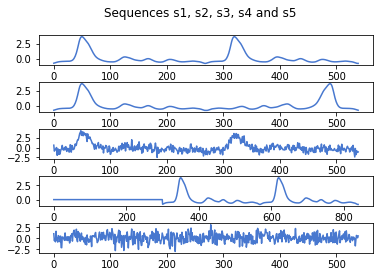

Distance 1-1 =  0.0
Distance 1-2 =  3.6372845640669906
Distance 1-3 =  13.116762357998967
Distance 1-4 =  4.267902060731969
Distance 1-5 =  22.209002603552925


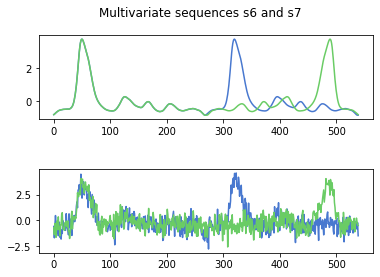

Distance 6-6 =  0.0
Distance 6-7 =  19.2810181829278


In [3]:
# displaying univariate sequences
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(5)
fig.suptitle('Sequences s1, s2, s3, s4 and s5')
ax1.plot(s1)
ax2.plot(s2)
ax3.plot(s3)
ax4.plot(s4)
ax5.plot(s5)
plt.subplots_adjust(hspace=0.6)
plt.show()

# computing DTW
path11, dist11 = metrics.dtw_path(s1, s1)
path12, dist12 = metrics.dtw_path(s1, s2)
path13, dist13 = metrics.dtw_path(s1, s3)
path14, dist14 = metrics.dtw_path(s1, s4)
path15, dist15 = metrics.dtw_path(s1, s5)

print('Distance 1-1 = ',dist11)
print('Distance 1-2 = ',dist12)
print('Distance 1-3 = ',dist13)
print('Distance 1-4 = ',dist14)
print('Distance 1-5 = ',dist15)

# displaying multivariate seauences
fig, (ax6, ax7) = plt.subplots(2)
fig.suptitle('Multivariate sequences s6 and s7')
ax6.plot(s6)
ax7.plot(s7)
plt.subplots_adjust(hspace=0.6)
plt.show()

# computing DTW
path66, dist66 = metrics.dtw_path(s6, s6)
path67, dist67 = metrics.dtw_path(s6, s7)
print('Distance 6-6 = ',dist66)
print('Distance 6-7 = ',dist67)

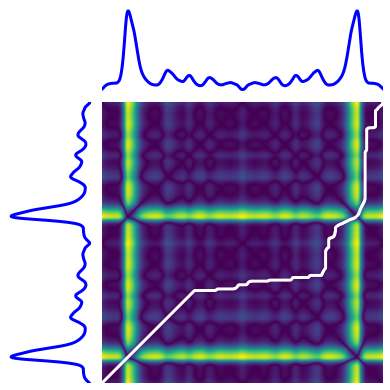

In [4]:
# the following code is adapted from the tslearn example
# to handle also sequences with different lenght
# in https://tslearn.readthedocs.io/en/stable/auto_examples/metrics/plot_dtw.html#sphx-glr-auto-examples-metrics-plot-dtw-py
def plot_dtw(s_y1, s_y2, path):

    plt.figure(1, figsize=(6, 6))

    # definitions for the axes
    left, bottom = 0.01, 0.1
    w_ts = h_ts = 0.2
    left_h = left + w_ts + 0.02
    width = 0.65 * (s_y2.size/s_y1.size)
    height = 0.65
    bottom_h = bottom + height + 0.02

    rect_s_y = [left, bottom, w_ts, height]
    rect_gram = [left_h, bottom, width, height]
    rect_s_x = [left_h, bottom_h, width, h_ts]

    ax_gram = plt.axes(rect_gram)
    ax_s_x = plt.axes(rect_s_x)
    ax_s_y = plt.axes(rect_s_y)

    mat = cdist(s_y1, s_y2)

    ax_gram.imshow(mat, origin='lower')
    ax_gram.axis("off")
    ax_gram.autoscale(False)
    ax_gram.plot([j for (i, j) in path], [i for (i, j) in path], "w-",
                 linewidth=3.)

    ax_s_x.plot(np.arange(s_y2.shape[0]), s_y2, "b-", linewidth=3.)
    ax_s_x.axis("off")
    ax_s_x.set_xlim((0, s_y2.shape[0] - 1))

    ax_s_y.plot(- s_y1, np.arange(s_y1.shape[0]), "b-", linewidth=3.)
    ax_s_y.axis("off")
    ax_s_y.set_ylim((0, s_y1.shape[0] - 1))

    plt.show()

    
# change the second argument in the following function to
# visualize the similarity path between the sequences 
# the 
path, dist = metrics.dtw_path(s1, s2)
plot_dtw(s1, s2, path)


### 2. KNN DTW classifier for gesture recognition

This example shows how to train and use a KNN classifiers based on DTW as distance metric. In particular, we use the [KNN classifier of tslearn](https://sequentia.readthedocs.io/en/latest/sections/classifiers/knn.html). This takes as input a list of Numpy arrays, which can have different lenght (as in the generated synthetic data). The inference time can be significant.

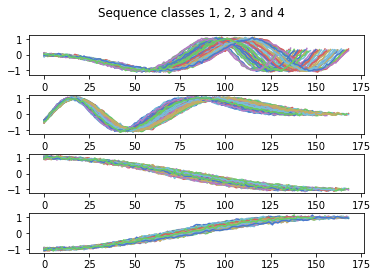

In [5]:
#SYNTHETIC DATA GENERATION

# empty list of gestures (1D numpy array with different lenght)
examples = []
# enpty list of labels (string of text)
labels = []

fig, (ax1, ax2, ax3, ax4) = plt.subplots(4)
fig.suptitle('Sequence classes 1, 2, 3 and 4')
plt.subplots_adjust(hspace=0.5)

noise = 0.05
length = 150
random_stretch_max = 20

#defining function to interpolate 1-D dimensional arrays
def lin_interp_1d(data, out_size):
    
    in_size = data.shape[0]
    x_in = np.arange(0,in_size)
    interpolator = scipy.interpolate.interp1d(x_in, data)
    x_out = np.arange(0,in_size-1,((in_size-1)/out_size))
    output = interpolator(x_out)
    output = output[0:out_size]
    
    return output

for i in range(200):
    if i < 50:
        t = np.linspace(0, np.pi, length)
        x = np.sin(-t ** 2) + np.random.normal(0,noise,t.shape)
        r = np.random.randint(-random_stretch_max,random_stretch_max)
        x = lin_interp_1d(x, x.size + r)
        examples.append(x)
        labels.append('g1')
        ax1.plot(x)
    elif i < 100:
        t = np.linspace(np.pi, 0, length)
        x = np.sin(t ** 2) + np.random.normal(0,noise,t.shape)
        r = np.random.randint(-random_stretch_max,random_stretch_max)
        x = lin_interp_1d(x, x.size + r)
        examples.append(x)
        labels.append('g2')
        ax2.plot(x)
    elif i < 150:
        t = np.linspace(-np.pi/2, np.pi/2, length)
        x = np.sin(-t) + np.random.normal(0,noise,t.shape)
        r = np.random.randint(-random_stretch_max,random_stretch_max)
        x = lin_interp_1d(x, x.size + r)        
        examples.append(x)
        labels.append('g3')
        ax3.plot(x)
    else:
        t = np.linspace(-np.pi/2, np.pi/2, length)
        x = np.sin(t) + np.random.normal(0,noise,t.shape)
        r = np.random.randint(-random_stretch_max,random_stretch_max)
        x = lin_interp_1d(x, x.size + r)
        examples.append(x)
        labels.append('g4')
        ax4.plot(x)


plt.subplots_adjust(hspace=0.5)
plt.show()


from sklearn.model_selection import train_test_split

#splitting the dataset in training and testing parts
ex_train, ex_test, lab_train, lab_test = train_test_split(examples, labels, test_size=0.1, random_state=77)

In [6]:
from sequentia.classifiers import KNNClassifier

#creating list of unique class labels
classes=['g1','g2','g3','g4']

# Creating the classifier and setting hyperparameters
clf = KNNClassifier(k=3, classes=classes)
clf.fit(ex_train, lab_train)

# Predicting the labels for the test set
lab_predict = clf.predict(ex_test, n_jobs=-1, verbose=False)

print(lab_predict)
print(lab_test)
print('Accuracy:',sklearn.metrics.accuracy_score(lab_test, lab_predict))

#alternatively we can use the evaluate() method, which also provides confusion matrix
#accuracy, confusion = clf.evaluate(ex_test, lab_test, verbose=True, n_jobs=-1)

['g3' 'g1' 'g1' 'g2' 'g1' 'g1' 'g3' 'g4' 'g2' 'g3' 'g4' 'g3' 'g1' 'g1'
 'g4' 'g4' 'g2' 'g1' 'g4' 'g4']
['g3', 'g1', 'g1', 'g2', 'g1', 'g1', 'g3', 'g4', 'g2', 'g3', 'g4', 'g3', 'g1', 'g1', 'g4', 'g4', 'g2', 'g1', 'g4', 'g4']
Accuracy: 1.0


### 3. HMM classifier for gesture recognition

This example shows how to train and use a HMM to classify gestures (i.e. time sequences). In particular, for each class we train a [GMMHMM](https://sequentia.readthedocs.io/en/latest/sections/classifiers/gmmhmm.html#) which are then combined in a [HMM classifier](https://sequentia.readthedocs.io/en/latest/sections/classifiers/gmmhmm.html#hidden-markov-model-classifier-hmmclassifier). This takes as input a list of Numpy arrays, which can have different lenght (as in the generated synthetic data). The parameter 'n_components' should be set equal to the number of variables in the time sequence.

In [9]:
from sequentia.classifiers import GMMHMM, HMMClassifier

#creating list of unique class labels
classes=['g1','g2','g3','g4']


# Create and fit a list of HMMs
hmms = []
for c in classes:
    # creating and initializing a GMMHMM (to uniform, so that training is more repeatible)
    hmm = GMMHMM(label=c, n_states=12, n_components=1, topology='left-right')
    hmm.set_uniform_initial()
    hmm.set_uniform_transitions()
    
    # selecting only trainign examples from current class (creating a new list)
    ex = [ex_train[i] for i, l in enumerate(lab_train) if l == c]
    
    # fitting the HMM
    print('fitting HMM for',c)
    hmm.fit(ex)
    
    # appending the trained HMM
    hmms.append(hmm)


# Create a classifier using the computed HMMs
clf = HMMClassifier()
clf.fit(hmms)

print('done')

fitting HMM for g1
fitting HMM for g2
fitting HMM for g3
fitting HMM for g4
done


In [10]:
# Using the method evaluate() to predic the labels for the test set
# and to compute accuracy and confusion 
accuracy, confusion = clf.evaluate(ex_test, lab_test, verbose=False, n_jobs=-1)
print('Accuracy:',accuracy)
print('Confusion Matrix\n',confusion)

# Alternatively we can use the usual predict() method
#lab_predict = clf.predict(ex_test, n_jobs=-1, verbose=False)

Accuracy: 1.0
Confusion Matrix
 [[7 0 0 0]
 [0 3 0 0]
 [0 0 4 0]
 [0 0 0 6]]


### 4. Follou-up assignment
In groups, build a Wekinator-like real-time system, including the integration of an arbitrary an input device/source/app and an arbitrary controlled sound making device/target/app. The core (ML) of the system must be coded in python, the rest can be done in any language/environment (likely with OSC interface). In groups, document your system design and implementation in a blog post, including a demo video (deadline in 2 weeks). 